Sample IMDB text:
 I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, C ...
Analyzing token positions from 50 to 70 (exclusive of 70).


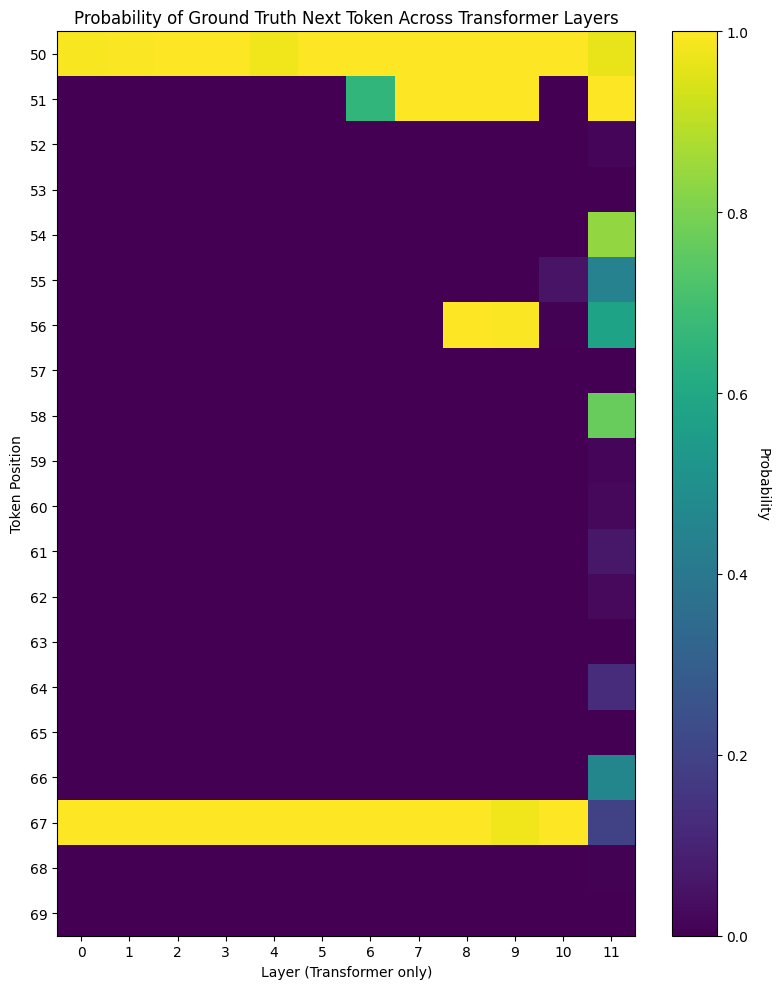

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

def text_to_input_ids(text):
    toks = tokenizer.encode(text, add_special_tokens=False)
    return torch.tensor(toks).unsqueeze(0).to(device)

def custom_logit_lens(model, tokenizer, input_ids, start_ix, end_ix, probs=True):
    """
    For each token position in [start_ix, end_ix), compute the probability (or logit)
    assigned to the ground-truth next token at that position for every *Transformer* layer
    in the model (skipping the embedding layer). Produces a heatmap of shape:
        (num_tokens, num_layers)
    where num_layers is typically 12 for GPT-2.
    """
    # Forward pass with hidden states
    outputs = model(input_ids, output_hidden_states=True)
    # The first entry is the embedding layer, so skip it:
    # hidden_states[0] = embedding output
    # hidden_states[1..N] = the actual N layers
    hidden_states = outputs.hidden_states[1:]  # Now we have 12 states for GPT-2

    # Retrieve the output embedding matrix
    # (Assumes "tied" embeddings)
    output_embedding = model.get_output_embeddings().weight  # shape: (vocab_size, hidden_size)

    num_layers = len(hidden_states)  # should be 12 for GPT-2
    results = {}

    # We only go up to second-to-last token for "next-token" predictions
    max_pos = min(end_ix, input_ids.size(1) - 1)
    for token_pos in range(start_ix, max_pos):
        gt_token_id = input_ids[0, token_pos + 1].item()
        layer_probs = []
        for layer_idx in range(num_layers):
            # hidden_states[layer_idx] has shape (batch_size, seq_len, hidden_size)
            hidden_vec = hidden_states[layer_idx][0, token_pos]  # shape: (hidden_size,)
            logits = torch.matmul(hidden_vec, output_embedding.T)
            if probs:
                logits = F.softmax(logits, dim=-1)
            layer_probs.append(logits[gt_token_id].item())
        results[token_pos] = layer_probs

    # Convert results to a 2D array: rows = token positions, cols = layers
    token_positions = sorted(results.keys())
    data = np.array([results[pos] for pos in token_positions])

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(8, len(token_positions)*0.4 + 2))
    im = ax.imshow(data, aspect='auto', cmap='viridis', vmin=0, vmax=1 if probs else None)

    ax.set_title("Probability of Ground Truth Next Token Across Transformer Layers")
    ax.set_xlabel("Layer (Transformer only)")
    ax.set_ylabel("Token Position")

    # X-axis: 0..(num_layers-1)
    ax.set_xticks(range(num_layers))
    ax.set_xticklabels(range(num_layers))

    # Y-axis: token positions
    ax.set_yticks(range(len(token_positions)))
    ax.set_yticklabels(token_positions)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Probability" if probs else "Logit", rotation=270, labelpad=15)
    plt.tight_layout()
    plt.show()

    return data

# ----- Example Usage -----

# Load model
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
model.eval()

# Load one example from IMDB
dataset = load_dataset("imdb", split="test")
sample_text = dataset[0]["text"]
print("Sample IMDB text:\n", sample_text[:300], "...")  # just show the first 300 chars

# Convert text to input IDs
input_ids = text_to_input_ids(sample_text)

# Define a smaller token range if desired, e.g., 50..70
start_ix = 50
end_ix = 70

# Make sure the range doesn't exceed the sequence length
end_ix = min(end_ix, input_ids.size(1)-1)
start_ix = min(start_ix, end_ix-1)

print(f"Analyzing token positions from {start_ix} to {end_ix} (exclusive of {end_ix}).")

# Run the custom logit lens
results_data = custom_logit_lens(
    model=model,
    tokenizer=tokenizer,
    input_ids=input_ids,
    start_ix=start_ix,
    end_ix=end_ix,
    probs=True
)


In [4]:
finetuned_model_path = "./results/checkpoint-3126"  # <-- update to your checkpoint path
finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_path)
finetuned_model.config.pad_token_id = tokenizer.pad_token_id
finetuned_model.to(device)
finetuned_model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

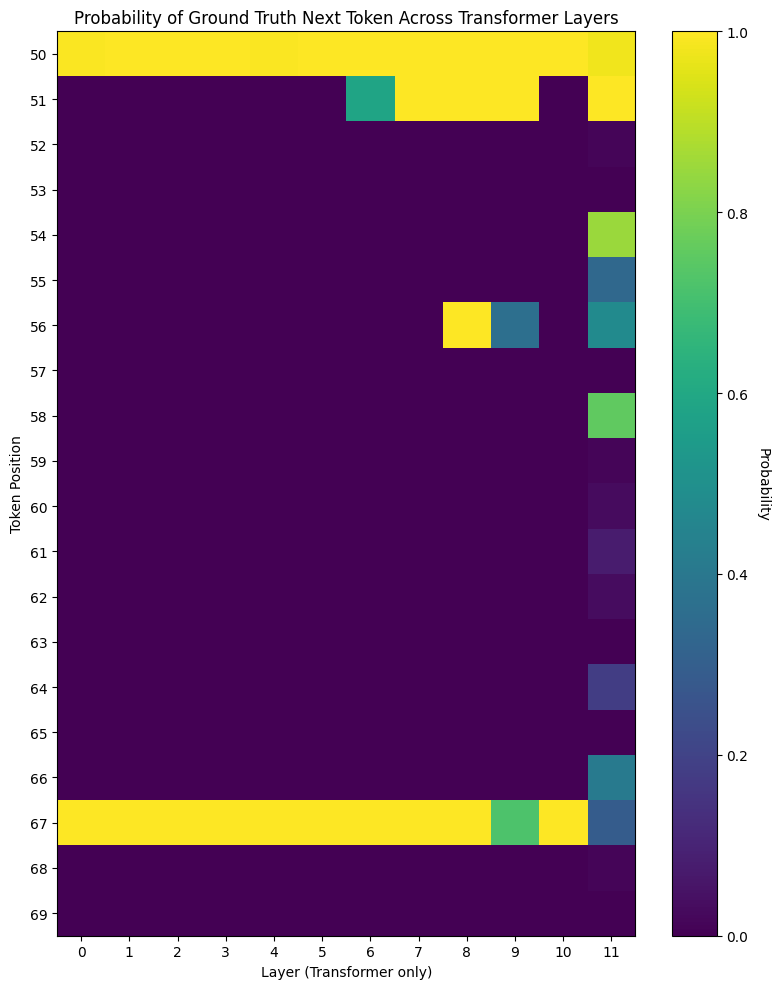

In [5]:
results_data = custom_logit_lens(
    model=finetuned_model,
    tokenizer=tokenizer,
    input_ids=input_ids,
    start_ix=start_ix,
    end_ix=end_ix,
    probs=True
)

In [1]:
import torch
import math
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

def compute_entropy(logits):
    """
    Given logits of shape (batch_size, vocab_size),
    compute the Shannon entropy of the predicted distribution.
    """
    probs = torch.nn.functional.softmax(logits, dim=-1)
    # sum over vocab dimension
    ent = -torch.sum(probs * torch.log(probs + 1e-9), dim=-1)
    return ent

def compute_perplexity(model, tokenizer, text, device='cuda'):
    """
    A simple way to approximate perplexity for a single text:
    1. Tokenize
    2. Compute the cross-entropy loss
    3. Exponentiate to get perplexity
    """
    inputs = tokenizer(text, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs['input_ids'])
    # outputs.loss is the average cross-entropy across tokens
    return math.exp(outputs.loss.item())

def analyze_model_outputs(model, tokenizer, texts, non_sentiment_tokens, device='cuda'):
    """
    - Measures average log probability of specified non-sentiment tokens (at the last token position).
    - Measures average output distribution entropy (also at the last token).
    - Measures average perplexity for the given texts.
    Returns a dictionary of these metrics.
    """
    all_entropies = []
    all_perps = []
    token_log_probs = []
    
    # Convert each non-sentiment token to its ID, filtering out invalid or missing ones
    token_ids = [tokenizer.convert_tokens_to_ids(t) for t in non_sentiment_tokens]
    token_ids = [tid for tid in token_ids if tid is not None and tid < tokenizer.vocab_size]
    
    for text in texts:
        # 1. Get logits for the last token in the sequence
        inputs = tokenizer(text, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # outputs.logits has shape (batch_size, seq_len, vocab_size)
        # We'll look at the distribution of the last token only
        last_logits = outputs.logits[0, -1, :]  # shape: (vocab_size,)
        
        # 2. Compute entropy
        ent = compute_entropy(last_logits.unsqueeze(0))  # shape: (1, vocab_size)
        all_entropies.append(ent.item())
        
        # 3. Compute log probabilities for the non-sentiment tokens
        log_probs = last_logits[token_ids] - torch.logsumexp(last_logits, dim=-1)
        token_log_probs.extend(log_probs.cpu().tolist())
        
        # 4. Compute perplexity on the entire sequence
        perp = compute_perplexity(model, tokenizer, text, device=device)
        all_perps.append(perp)
    
    return {
        'average_entropy': float(np.mean(all_entropies)),
        'average_log_prob_non_sentiment': float(np.mean(token_log_probs)),
        'average_perplexity': float(np.mean(all_perps))
    }

def compare_models(base_model_path, finetuned_model_path, tokenizer, texts, non_sentiment_tokens, device='cuda'):
    """
    Loads the base and fine-tuned models, evaluates them on:
      - Entropy of last-token distribution
      - Log prob of non-sentiment tokens
      - Perplexity on neutral texts
    Returns two dictionaries with stats for each model.
    """
    base_model = AutoModelForCausalLM.from_pretrained(base_model_path).to(device)
    finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_path).to(device)
    
    base_model.eval()
    finetuned_model.eval()
    
    base_stats = analyze_model_outputs(base_model, tokenizer, texts, non_sentiment_tokens, device=device)
    finetuned_stats = analyze_model_outputs(finetuned_model, tokenizer, texts, non_sentiment_tokens, device=device)
    
    return base_stats, finetuned_stats

if __name__ == "__main__":
    # Example usage
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    
    # Sample neutral texts that don't contain strong sentiment
    neutral_texts = [
        "The cat sat on the mat under the tree.",
        "This is a statement about a table in a room.",
        "An example sentence that has no emotional words."
    ]
    
    # A small set of non-sentiment tokens to test
    non_sentiment_tokens = ["table", "chair", "building", "sky", "cloud", "integer", "formula"]
    
    # Paths to your models
    base_model_path = "gpt2"
    finetuned_model_path = "./results/checkpoint-3126"  # update as needed
    
    base_stats, finetuned_stats = compare_models(
        base_model_path,
        finetuned_model_path,
        tokenizer,
        neutral_texts,
        non_sentiment_tokens,
        device=device
    )
    
    print("Base Model Stats:", base_stats)
    print("Finetuned Model Stats:", finetuned_stats)


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Base Model Stats: {'average_entropy': 4.366019566853841, 'average_log_prob_non_sentiment': -16.162607102167037, 'average_perplexity': 160.87188658788926}
Finetuned Model Stats: {'average_entropy': 4.732781092325847, 'average_log_prob_non_sentiment': -15.443001520066034, 'average_perplexity': 49802.45557762728}
